In [38]:
#import the csv file into the collab
from google.colab import files
uploaded = files.upload()

Saving dynamic_supply_chain_logistics_dataset - dynamic_supply_chain_logistics_dataset.csv to dynamic_supply_chain_logistics_dataset - dynamic_supply_chain_logistics_dataset (1).csv


In [39]:
#Libraries info
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import joblib
import shap
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [40]:
df=pd.read_csv("dynamic_supply_chain_logistics_dataset - dynamic_supply_chain_logistics_dataset.csv")
df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 0:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 1:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 2:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 3:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 4:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [41]:
print(df.shape) # printing no of rows and columns in the data set

(32065, 26)


In [42]:
df.columns.value_counts() # checking how many times the coumns and repeated for the duplicates

,count
timestamp,1
vehicle_gps_latitude,1
vehicle_gps_longitude,1
fuel_consumption_rate,1
eta_variation_hours,1
traffic_congestion_level,1
warehouse_inventory_level,1
loading_unloading_time,1
handling_equipment_availability,1
order_fulfillment_status,1


In [43]:
df.isnull().sum() #finding null values and counting them

,0
timestamp,0
vehicle_gps_latitude,0
vehicle_gps_longitude,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0


In [44]:
#clean column names->column names are clean, lowercase, no spaces, no slashes
#Removes extra spaces from start and end.Replaces spaces with underscores.Replaces slashes (/) with underscores.Converts everything to lowercase
df.columns = [c.strip().replace(" ", "_").replace("/", "_").lower() for c in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        32065 non-null  object 
 1   vehicle_gps_latitude             32065 non-null  float64
 2   vehicle_gps_longitude            32065 non-null  float64
 3   fuel_consumption_rate            32065 non-null  float64
 4   eta_variation_hours              32065 non-null  float64
 5   traffic_congestion_level         32065 non-null  float64
 6   warehouse_inventory_level        32065 non-null  float64
 7   loading_unloading_time           32065 non-null  float64
 8   handling_equipment_availability  32065 non-null  float64
 9   order_fulfillment_status         32065 non-null  float64
 10  weather_condition_severity       32065 non-null  float64
 11  port_congestion_level            32065 non-null  float64
 12  shipping_costs    

In [45]:
#Parse timestamp
#This finds the first column whose name contains "timestamp".[0] → selects the first match.
ts_col = [c for c in df.columns if "timestamp" in c][0]
#Converts that column into datetime format (YYYY-MM-DD HH:MM:SS).errors="coerce" → if there are invalid dates, they will become NaT (Not a Time) instead of breaking the code.
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
#Extracts the year,month,day,hour,weekday from the timestamp
df["year"] = df[ts_col].dt.year
df["month"] = df[ts_col].dt.month
df["day"] = df[ts_col].dt.day
df["hour"] = df[ts_col].dt.hour
df["weekday"] = df[ts_col].dt.weekday
df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation,year,month,day,hour,weekday
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,...,0.978599,0.506152,0.885291,Moderate Risk,9.110682,2021,1,1,0,4
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,...,0.918586,0.980784,0.544178,High Risk,8.175281,2021,1,1,1,4
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,...,0.394215,0.998633,0.803322,High Risk,1.283594,2021,1,1,2,4
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,...,0.905444,0.993320,0.025977,High Risk,9.304897,2021,1,1,3,4
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,...,0.258702,0.912433,0.991122,High Risk,7.752484,2021,1,1,4,4


In [46]:
#Displays the timestamp column + the derived columns for the first 5 rows.
df[[ts_col, "year", "month", "day", "hour", "weekday"]].head(5)

,timestamp,year,month,day,hour,weekday
0,2021-01-01 00:00:00,2021,1,1,0,4
1,2021-01-01 01:00:00,2021,1,1,1,4
2,2021-01-01 02:00:00,2021,1,1,2,4
3,2021-01-01 03:00:00,2021,1,1,3,4
4,2021-01-01 04:00:00,2021,1,1,4,4


In [47]:
df[["year", "month", "day", "hour", "weekday"]].describe()

,year,month,day,hour,weekday
count,32065.000000,32065.000000,32065.000000,32065.000000,32065.000000
mean,2022.360830,6.155746,15.695774,11.499641,3.000000
std,1.066718,3.361877,8.783507,6.922484,2.000748
min,2021.000000,1.000000,1.000000,0.000000,0.000000
25%,2021.000000,3.000000,8.000000,5.000000,1.000000
50%,2022.000000,6.000000,16.000000,11.000000,3.000000
75%,2023.000000,9.000000,23.000000,17.000000,5.000000
max,2024.000000,12.000000,31.000000,23.000000,6.000000


In [48]:
#dataset spans multiple years/months or just one
print("Years:", df["year"].unique())
print("Months:", df["month"].unique())
print("Weekdays:", df["weekday"].unique())

Years: [2021 2022 2023 2024]
Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Weekdays: [4 5 6 0 1 2 3]


risk_classification
High Risk        23944
Moderate Risk     5011
Low Risk          3110
Name: count, dtype: int64


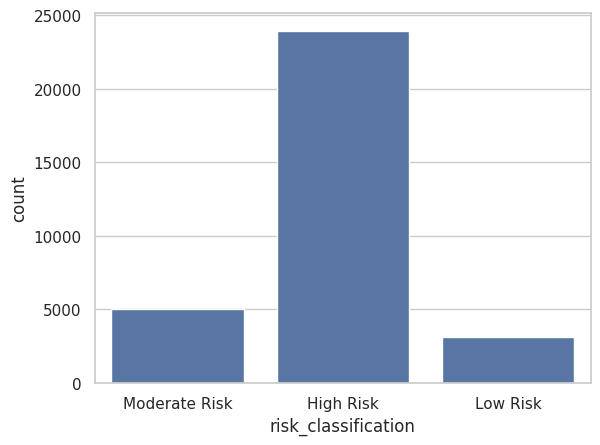

In [49]:
#Target column
target_col = "risk_classification"#this is the multi-class classification label:"Low Risk", "Moderate Risk", "High Risk"
df[target_col] = df[target_col].astype(str).str.title()#Ensures the column is string type (in case it was numeric or categorical before).str.title() → converts text to Title Case (first letter uppercase)
print(df[target_col].value_counts())#Counts how many rows belong to each category
#easy to see imbalance at a glance.if "Low Risk" is much higher than "High Risk", your model might need balancing techniques (SMOTE, class weights)
sns.countplot(data=df, x=target_col)
plt.show()

In [50]:
df.columns

Index(['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude',
       'fuel_consumption_rate', 'eta_variation_hours',
       'traffic_congestion_level', 'warehouse_inventory_level',
       'loading_unloading_time', 'handling_equipment_availability',
       'order_fulfillment_status', 'weather_condition_severity',
       'port_congestion_level', 'shipping_costs', 'supplier_reliability_score',
       'lead_time_days', 'historical_demand', 'iot_temperature',
       'cargo_condition_status', 'route_risk_level', 'customs_clearance_time',
       'driver_behavior_score', 'fatigue_monitoring_score',
       'disruption_likelihood_score', 'delay_probability',
       'risk_classification', 'delivery_time_deviation', 'year', 'month',
       'day', 'hour', 'weekday'],
      dtype='object')

In [51]:
# Cell 8: Feature selection Keeping only features available in your dataset
features = [
    "fuel_consumption_rate","eta_variation_(hours)","traffic_congestion_level",
    "warehouse_inventory_level","loading_unloading_time",
    "handling_equipment_availability","weather_condition_severity",
    "port_congestion_level","shipping_costs","supplier_reliability_score",
    "lead_time_(days)","historical_demand","iot_temperature",
    "cargo_condition_status","route_risk_level","customs_clearance_time",
    "driver_behavior_score","fatigue_monitoring_score",
    "hour","month","weekday"
]
#cross-checks the list with your actual dataframe (df.columns).If some features are missing in your dataset (maybe not collected or dropped earlier), they will be automatically excluded.
features = [f for f in features if f in df.columns]
print("Features:", features)

Features: ['fuel_consumption_rate', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'hour', 'month', 'weekday']


In [52]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [57]:
#Train/Test split (time-based)
max_ts = df[ts_col].max()#latest timestamp in your dataset.
test_start = max_ts - pd.Timedelta(days=90)#Defines the start date for the test set,sub 90 days from the maximum timestamp.
train_df = df[df[ts_col] < test_start]# data before the last 90 days
test_df  = df[df[ts_col] >= test_start]#most recent 90 days
#X_train = feature columns (inputs) from training set
#y_train = target column (risk_classification) from training set
X_train, y_train = train_df[features], train_df[target_col]
X_test,  y_test  = test_df[features],  test_df[target_col]

print("Train:", X_train.shape, "Test:", X_test.shape)#Training set → 29904 rows × 19 features,Test set → 2161 rows × 19 features

Train: (29904, 19) Test: (2161, 19)


In [56]:
#Preprocessing
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()#select all numeric columns
cat_cols = [c for c in X_train.columns if c not in num_cols]#select all categorical columns
#Create pipelines for preprocessing
#numeric pipeline
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),#fills missing values with the column median (robust to outliers)
    ("scaler", StandardScaler()) #scales numeric features to mean=0, std=1 → makes models like Logistic Regression or SVM work better.
])
#categorical pipeline
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),#fills missing categorical values with the most common category.
    ("ohe", OneHotEncoder(handle_unknown="ignore"))#converts categorical variables into dummy variables (0/1).handle unknown ensures unseen categories in test data won’t break the model.
])
#clean, imputed, scaled, encoded feature matrix ready for training.
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),#only to numeric columns
    ("cat", cat_transformer, cat_cols)#only to categorical columns
])

In [59]:
!pip install -q gdown xgboost lightgbm shap fastapi uvicorn

In [62]:
# RandomForest Model

from sklearn.pipeline import Pipeline
rf = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RandomForest Results")
print(classification_report(y_test, y_pred))
print("F1-macro:", f1_score(y_test, y_pred, average="macro"))
#macro F1 tells you if the model is biased toward majority class (Low Risk) or performing well across all (High Risk, Moderate Risk too)


RandomForest Results
               precision    recall  f1-score   support

    High Risk       0.76      1.00      0.86      1637
     Low Risk       0.00      0.00      0.00       215
Moderate Risk       0.00      0.00      0.00       309

     accuracy                           0.76      2161
    macro avg       0.25      0.33      0.29      2161
 weighted avg       0.57      0.76      0.65      2161

F1-macro: 0.2873442162541689


In [67]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels into numbers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Re-train XGBoost with numeric labels
from xgboost import XGBClassifier
xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42))
])

xgb.fit(X_train, y_train_enc)
y_pred_xgb = xgb.predict(X_test)

# Decode predictions back to original class labels
y_pred_labels = le.inverse_transform(y_pred_xgb)

# Evaluation
print("XGBoost Results")
print(classification_report(y_test, y_pred_labels))
print("F1-macro:", f1_score(y_test, y_pred_labels, average="macro"))

XGBoost Results
               precision    recall  f1-score   support

    High Risk       0.76      0.99      0.86      1637
     Low Risk       0.00      0.00      0.00       215
Moderate Risk       0.17      0.01      0.01       309

     accuracy                           0.75      2161
    macro avg       0.31      0.33      0.29      2161
 weighted avg       0.60      0.75      0.65      2161

F1-macro: 0.2906477874708098


In [68]:
#Save model

os.makedirs("models", exist_ok=True)
joblib.dump(xgb, "models/final_model.joblib")
print("Model saved!")

Model saved!


In [69]:
# Test inference

loaded = joblib.load("models/final_model.joblib")
sample = X_test.iloc[:2]
print("Predictions:", loaded.predict(sample))

Predictions: [0 0]
